### Import Libraries

In [72]:
# Ignore cuDDa warning messages
import warnings
import os
warnings.filterwarnings('ignore')



# # Expands the Jupyter Notebook Output Size to fit your window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Load in tensorboard
%load_ext tensorboard

# Change the working directory back to the original to keep paths the same between files
os.chdir(r'C:\Users\Maxwell\PycharmProjects\TAMU-ECEN-403-IFPTSND\ECEN_403_IFM\TAMU-ECEN-403-IFPTSND')

import datetime
import pickle
import sys
from os.path import join, isfile
import shutil

import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
import tensorflow.keras.backend as kb
from tensorflow.python.ops import math_ops
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import Sequential

from explore_entities import Graph_Entities
import ipywidgets as widgets
from ipywidgets import Layout, GridBox
from IPython.display import display
import matplotlib.pyplot as plt

import warnings
import os
import math

from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Allows for scrolling windows to be very large

In [73]:
%%javascript
    IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

### Import TF_models and truncate the entities to only contain 880 companies

In [74]:
from tensorflow_models import TF_Models, Ein_Multiply, leaky_relu, rank_loss_func
DMJ = TF_Models('./ignorable_data/data_sets/NASDAQ_Cleaned - Contains ZUMZ/', './ignorable_data/models/[55, 25, 20]_split/', reload=False)
data_splits = DMJ.split_data()

DMJ.Normalized_Adjacency_Matrix = DMJ.Normalized_Adjacency_Matrix[0:880, 0:880]
DMJ.XX_tf = DMJ.XX_tf[0:-1, :, :]
DMJ.YY_tf = DMJ.YY_tf[0:-1, :]
DMJ.RR_tf = DMJ.RR_tf[0:-1, :]
DMJ.entities = DMJ.entities[0:-1]
DMJ.entities_idx.pop('ZUMZ')

model = DMJ.generate_model()

from graph_predictions import Graph_Predictions
GP = Graph_Predictions("./ignorable_data/models/[55, 25, 20]_split/", "./ignorable_data/strategies/RL_validation_strategies/", 'x_val', DMJ)

GridBox(children=(Dropdown(description='Model Types:', options=('lstm', 'lstm_gcn_1', 'lstm_gcn_2', 'lstm_gcn_…

# What if we split the data into time batches ourselves and trained them?

In [75]:
# Given a total and list of splits, evenly distributes the total amount proportional to the given list
def split_windows(total, percentages_list):
    # Get a sum of the initial total
    percentage_sum = sum(percentages_list)

    # Create a new list based on a percentage of the total
    new_splits = []
    for perc in percentages_list:
        new_splits.append(int(total * (perc / percentage_sum)))
    
    # Where to shift the extra days that don't exactly divide between the values
    if sum(new_splits) != total:
        new_splits[-1] = new_splits[-1] + (total - sum(new_splits))

    return new_splits

# one_x = DMJ.XX_tf[0:2, :, :]
# one_y = DMJ.YY_tf[0:2, :]
one_x = DMJ.XX_tf
print(DMJ.XX_tf.shape)
one_y = DMJ.YY_tf

# one_x = DMJ.XX_tf[0:-1, :, :]
# one_y = DMJ.YY_tf[0:-1, :]

# # Given a dataset, let's section off a fifth of the data to be used for testing purposes
# time_split = [1000, 239,]
# x_train, x_test = tf.split(one_x, split_windows(one_x.shape[1], time_split),
#                                   axis=1)
# y_train, y_test = tf.split(one_y, split_windows(one_y.shape[1], time_split),
#                                   axis=1)
# rr_train, rr_test = tf.split(DMJ.RR_tf, split_windows(one_y.shape[1], time_split),
#                                      axis=1)

# Given a dataset, let's section off a fifth of the data to be used for testing purposes
time_split = [90, 710, 239, 199]
time_split = [55, 25, 20]

time_split = [30, 25, 25, 20]
x_g, x_train, x_val, x_test = tf.split(one_x, split_windows(one_x.shape[1], time_split),
                                  axis=1)
y_g, y_train, y_val, y_test = tf.split(one_y, split_windows(one_y.shape[1], time_split),
                                  axis=1)
rr_g, rr_train, rr_val, rr_test = tf.split(DMJ.RR_tf, split_windows(one_y.shape[1], time_split),
                                     axis=1)

# y_train = y_train[:, -1]
# y_val = y_val[:, -1]

# # Once we have the data partitioned, let's split it into 8 sets of 125
# batch_splits = [1]*8
# # Create a list of 8 different time batches
# x_train_batches = []
# x_train_batches.append(tf.split(x_train, split_windows(x_train.shape[1], batch_splits), axis=1))
# x_train_batches = [item for sublist in x_train_batches for item in sublist]

# y_train_batches = []
# y_train_batches.append(tf.split(y_train, split_windows(x_train.shape[1], batch_splits), axis=1))
# y_train_batches = [item for sublist in y_train_batches for item in sublist]

# # Lets try truncating the values for the labels to only be the final value
# for i in range(len(y_train_batches)):
#     y_train_batches[i] = y_train_batches[i][:, -1]

# print(x_train[0, -1, 0])

# print(rr_train[0, -1])

# print(x_val[0, 0, 0])
# print(y_train[0, -1])
# for set in [x_train, x_g, x_val, x_test]:
print(x_val.shape)
print(x_train.shape)

print(x_train[0, 0, 0])
print(x_train[0, 1, 0])
print(rr_train[0, 0])

print(x_train[0, -1, 0])
print(x_train[0, -2, 0])
print(x_train[0, -2:-1, 0])

print(keras.Input(shape=(x_train.shape[1], x_train.shape[2])).shape)

(880, 1239, 5)
(880, 309, 5)
(880, 309, 5)
tf.Tensor(0.455917, shape=(), dtype=float32)
tf.Tensor(0.461538, shape=(), dtype=float32)
tf.Tensor(0.012328968, shape=(), dtype=float32)
tf.Tensor(0.425614, shape=(), dtype=float32)
tf.Tensor(0.415741, shape=(), dtype=float32)
tf.Tensor([0.415741], shape=(1,), dtype=float32)
(None, 309, 5)


### Let's create the one-hot encoded adjacency matrix to work with

In [76]:
import explore_entities
# Load in the code
GE = Graph_Entities('./ignorable_data/data_sets/NASDAQ_Cleaned - Contains ZUMZ - Yuning/')
# Generate the baseline components we're wokring with
NAM, Adj, Rel = GE.get_matrix_components()

GridBox(children=(Text(value='Loading Normalized Adjacency Matrix:', disabled=True, layout=Layout(width='auto'…

GridBox(children=(Text(value='Loading Normalized Adjacency Matrix:', disabled=True, layout=Layout(width='auto'…

### Let's check the dimensionality of normalized adjacency matrix we have so far 

In [ ]:
# Checks to see if a matrix is normalized among it's rows and columns to 6 decimal places
def is_normalized(m):
    m_t = np.transpose(m)
    r_trigger = True
    c_trigger = True
    for i in m:
        if (round(np.sum(i), 6)) != 1 and r_trigger:
            print('Rows Not Normalized')
            r_trigger = not r_trigger
    for i in m_t:
        if (round(np.sum(i), 6)) != 1 and c_trigger:
            print('Columns Not Normalized')
            c_trigger = not c_trigger
    
    if r_trigger and c_trigger:
        print('Normalized')
        return True
    else:
        return False

# Created with D^-1/2 * A * D^-1/2
print(f"Symetrically Normalized DMJ: {NAM.shape}")
is_normalized(NAM)
print("####")
# All relationships, but still seperated by the different groups
print(f"One-Hot Encoded Relationships Split by Group: {Rel.shape}")
print("####")
# All relationships squished into one matrix
print(f"One-Hot Encoded All Relationships: {Adj.shape}")
is_normalized(Adj)
print("####")

None

print(np.sum(Rel[9, :, :])/2)

### Split the training data

In [ ]:
# Given a total and list of splits, evenly distributes the total amount proportional to the given list
def split_windows(total, percentages_list):
    # Get a sum of the initial total
    percentage_sum = sum(percentages_list)

    # Create a new list based on a percentage of the total
    new_splits = []
    for perc in percentages_list:
        new_splits.append(int(total * (perc / percentage_sum)))
    
    # Where to shift the extra days that don't exactly divide between the values
    if sum(new_splits) != total:
        new_splits[-1] = new_splits[-1] + (total - sum(new_splits))

    return new_splits

one_x = DMJ.XX_tf
one_y = DMJ.YY_tf

time_split = [90, 710, 239, 199]
time_split = [55, 25, 20]

time_split = [30, 25, 25, 20]
x_g, x_train, x_val, x_test = tf.split(one_x, split_windows(one_x.shape[1], time_split),
                                  axis=1)
y_g, y_train, y_val, y_test = tf.split(one_y, split_windows(one_y.shape[1], time_split),
                                  axis=1)
rr_g, rr_train, rr_val, rr_test = tf.split(DMJ.RR_tf, split_windows(one_y.shape[1], time_split),
                                     axis=1)

# For the Adjacency Matrix we would like to introduce to the algorithm
# N x N x K
adj_matrix = np.transpose(Rel)

# Since some implementations removed the last company...
# if adj_matrix.shape[0] == 881:
#     adj_matrix = adj_matrix[0:-1, 0:-1, :]

# Loading in an already trained LSTM model & Adding Topographical Layer

In [ ]:
tf.random.set_seed(1337)

optimizer = tf.keras.optimizers.Adam(
            learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
            name='Adam'
        )

# Create a function for the Tensorflow implementation of leaky_relu
def leaky_relu(x):
    return tf.keras.layers.LeakyReLU(alpha=0.2)(x)

# Shouldn't be neccessary if we use softmax
# def normalize_adj_matrix(adj):
#     degree = tf.reduce_sum(adj, axis=0)
#     inv_degree = tf.math.reciprocal(degree)
#     diag_inv_degree = tf.linalg.diag(inv_degree)
#     norm_adj = diag_inv_degree * adj
#     return norm_adj

hidden_units = 64
activation = leaky_relu
do = 0

# Assuming all time steps are the same size, we can just use the first item to determine input shape
# For the time-series data
input_seq = keras.Input(shape=(x_train.shape[1], x_train.shape[2]))
    
# Create the input layer for the data that comes from outside the graph (needs to be NxN)
input_rel = keras.Input(shape=(adj_matrix.shape[1], adj_matrix.shape[2]))


# Load in an already trained LSTM Model
file_name = '2-20-21-1_LSTM_[25,25,20]_NoDropout_100Epoch_80BatchSize_1000ALPHA'
model_path = './ignorable_data/models/[55, 25, 20]_split/'
pre_trained_lstm = tf.keras.models.load_model(model_path + f'{file_name}', compile=False,
                                              custom_objects={'leaky_relu': leaky_relu})

# Change the names to avoid conflicts
pre_trained_lstm.layers[0]._name = 'Original-InputLayer'
pre_trained_lstm.layers[1]._name = 'Original-LSTM'
pre_trained_lstm.layers[2]._name = 'Original-Dense'

# # Make sure that the weights for the lstm model cannot be updated
pre_trained_lstm.layers[0].trainable = False
pre_trained_lstm.layers[1].trainable = False
pre_trained_lstm.layers[2].trainable = False

# This is the LSTM layer, input_seq is not carried over from the original because we don't care how it was initalized
x = pre_trained_lstm.layers[1](input_seq)

# Experimental vector multiplication
# W = tf.Variable(tf.random.uniform(shape=[adj_matrix.shape[0], 1]))
# W = tf.keras.layers.Variable
# y = Ein_Multiply()([input_rel, W], "ij, k->ik")

# This is a seperate input layer that will take in the relational matrix
# Dimensionality: N x N x 1
# y = tf.keras.layers.Dense(1, activation=activation)(input_rel)

# These are the similarity values
# Dimensionality: N x T x N

# As a memory test, let's only take 1 time embedding and see if our computer can handle it
x = x[:, -1, :]

# w = Ein_Multiply()([w, x], "ij, jk->ik")

print(x.shape)

# w = MaskedDense(880)(x)
e_bar = square_keep_self_loop(880)(x)
# w = tf.matmul(w, x)

# This is where we can decide to add an additional dense layer for learning or not, but we're currently not implementing this

# Lastly, we want to recombine the original embeddings and with the new ones, so that both data is present for learning
# Dimensionality: NxTxD*2

# # This is the original Dense Layer
# x = pre_trained_lstm.layers[2](x)

# This is a new Dense layer we might want to experiment with
o = Dense(1, activation=activation)(e_bar)


model = tf.keras.Model(inputs=[input_seq], outputs=o)

losses = []

In [ ]:
from tensorflow_models import rank_loss_correct_pred_rr

# View what we just created
# model.compile(loss=rank_loss_rr, optimizer=optimizer)
model.compile(loss=rank_loss_correct_pred_rr, optimizer=optimizer)
model.summary()

In [ ]:
# for i in range(0, len(model.layers)):
#     print(model.layers[i].name)
tf.print(model.layers[13].name)
tf.print(model.layers[13].output)

In [ ]:
tf.config.run_functions_eagerly(True)

checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            save_best_only=True)

def scheduler(epoch, lr):
    return 0.00035

inputs_train = [x_train]
train_labels = y_train

inputs_val = [x_val]
val_labels = y_val

# If we're using the GCN
inputs_train.append(adj_matrix)
inputs_val.append(adj_matrix)

# int(inputs_train.shape[0])

history = model.fit(inputs_train, train_labels, batch_size=int(inputs_train[0].shape[0]),
                              epochs=0, validation_data=(inputs_val, val_labels),
                   callbacks=[model_checkpoint_callback,
                             tf.keras.callbacks.LearningRateScheduler(scheduler,
                                                                      verbose=0)])

model.load_weights(checkpoint_filepath)

for h in history.history['val_loss']:
    losses.append(h)
plt.plot(losses)

In [ ]:
# model.predict([x_train, DMJ.Normalized_Adjacency_Matrix], batch_size=880)
model_save = model

In [ ]:
# for h in history.history['val_loss']:
#     losses.append(h)
# plt.plot(losses)

DMJ.Normalized_Adjacency_Matrix.shape

In [ ]:
DMJ.model = model
DMJ.model_name = "3-29-21-1_[25,25,20]_400Epoch_NaiveWeightAlpha_1000_1.02val_loss"
DMJ.save_model()

In [ ]:
# model_name = "2-16-21-Seq1LSTM-F-64HU-[800,239,200]split-full_y"
# new_directory = './ignorable_data/prediction_results/[55, 25, 20]_splits/'
# GP.generate_validation_prediction_json_SplitBatch_nofeat(model_name, new_directory, x_g, x_val, sliding_window=30)
# GP.generate_validation_prediction_json_SplitBatch_close_gap(model_name, new_directory, x_g, x_val, sliding_window=30)
model_name = '3-28-21-1_[25,25,20]_100Epoch_BrokenNaiveAlpha_1000'
model_dir = './ignorable_data/models/[55, 25, 20]_split'
# model_dir = 'G:\Shared drives\Max Huffman - ECEN 403 404 URS Research 2020 2021\Datasets\models'
past = x_train
future = x_val
# new_dir = 'G:\Shared drives\Max Huffman - ECEN 403 404 URS Research 2020 2021\Datasets\predictions\pc_version'
new_dir = './ignorable_data/prediction_results/[55, 25, 20]_splits/'
sliding_window = x_val.shape[1]

window = x_train.shape[1]
input_Adj_matrix = adj_matrix
# GP.generate_predictions(model_name, model_dir, past, future, new_dir, window,
#                         model_type='gcn', input_Adj_matrix=adj_matrix, batch_size=880)
GP.generate_predictions(model_name, model_dir, past, future, new_dir, window, model_type='lstm', batch_size=880)
# GCN_output = GP.return_embeddings(model_name, model_dir, past, future, new_dir, w, model_type='gcn')
# embeddings = GP.return_embeddings(model_name, model_dir, past, future, new_dir, window, model_type='gcn')

#     model_name = '2-20-21-1_LSTM_[25,25,20]_NoDropout_35Epoch_80BatchSize_IncreasedVariedLR_RRMSE'
#     GP.generate_predictions(model_name, model_dir, past, future, new_dir, w)
# GP.generate_validation_prediction_json_SplitBatch(model_name, new_dir, x_g, x_val, sliding_window=sliding_window)

In [ ]:
# Given the training set, these are the validation values that are output from the LSTM model
print(embeddings.shape)

# This is the NAM that we are using to aggregate the embedding results
print(DMJ.Normalized_Adjacency_Matrix[6,6])

# This should be the aggregated values output from using the NAM (The dimensions look fine)
# new_embeddings = tf.einsum('ntd,nm->mtd', embeddings, DMJ.Normalized_Adjacency_Matrix)
new_embeddings = tf.einsum('mn,ntd->mtd', DMJ.Normalized_Adjacency_Matrix, embeddings)
print(new_embeddings.shape)

print(embeddings[0, -7, 0:10])
# print(embeddings[0, -1, 0:10])
print('  ')
print(new_embeddings[0, -7, 0:10])
# print(new_embeddings[0, -1, 0:10])

# print(tf.subtract(embeddings[0, -2, 0:10], embeddings[0, -1, 0:10]))
# print(tf.subtract(new_embeddings[0, -2, 0:10], new_embeddings[0, -1, 0:10]))

In [ ]:
# Above are the output embeddings of the LSTM layer
# Below is 1 output prediction for a simple NAM Aggregate added to a pre-trained LSTM
GCN_output.shape

In [ ]:
p_file_name = '3-28-21-1_[25,25,20]_100Epoch_BrokenNaiveAlpha_1000309win_309past_309fut'
p_file_dir = '.\ignorable_data\prediction_results\[55, 25, 20]_splits'
# p_file_dir = 'G:\Shared drives\Max Huffman - ECEN 403 404 URS Research 2020 2021\Datasets\predictions\pc_version'
future = x_val
new_dir = './ignorable_data/datablocks/[55, 25, 20]_splits/'
close_gap = False

use_argmin = False
yesterday_pred = False
GP.generate_prediction_results(p_file_name, p_file_dir, future, new_dir,
                               close_gap=close_gap, use_argmin=use_argmin, yesterday_pred=yesterday_pred, rr_labels=False)

for root, dirs, files in os.walk(r'C:\Users\Maxwell\PycharmProjects\TAMU-ECEN-403-IFPTSND\ECEN_403_IFM\TAMU-ECEN-403-IFPTSND\ignorable_data\datablocks\[55, 25, 20]_splits'):
    for filename in files:
#         GP.generate_prediction_results(filename, p_file_dir, future, new_dir, close_gap=close_gap, use_argmin=use_argmin, yesterday_pred=yesterday_pred)
        GP.add_daily_value_to_datablock(filename, './ignorable_data/datablocks/[55, 25, 20]_splits')
        GP.add_daily_value_to_datablock_discontinuous(filename, './ignorable_data/datablocks/[55, 25, 20]_splits')
        GP.add_cumulative_return_ratio_discontinuous(filename, './ignorable_data/datablocks/[55, 25, 20]_splits')
        None


# use_argmin = True
# yesterday_pred = False
# GP.generate_prediction_results(p_file_name, p_file_dir, future, new_dir, close_gap=close_gap, use_argmin=use_argmin, yesterday_pred=yesterday_pred)
# # GP.generate_model_diagnostics_given_sets(p_file_dir + f'/{p_file_name}', future, datablock_folder=new_dir, try_all_pred=False)

In [ ]:
def plot_company(n):
    # n = 597
    # n = 488
    # n = 161
    # n = 561
    # n = 440
    # n = 200
    # # Argmin
    # n = 780

    # n = 876
    # n = 110
    r = 1
    # n = 100
    # n=0

    r=1
    fig, ax = plt.subplots(figsize=(20, 10))
#     ax.set_ylim([0,1])
    ax.set_xlim([20,80])

    time = tf.concat([x_train, x_val, x_test], axis=1)

    # ax = fig.add_subplot()
    for i in range(r):
    #     print(f'{i+n*r} ', end='')
    #     ax.plot(time[i+n*r, :, 0])
        ax.plot(x_val[i+n*r, :, 0], label='Closing Price', linewidth=2, color='black')
    #     ax.plot(rr_val[i+n*r, :], label='Return Ratio')

        ax.plot(A[:, i+n*r], label='LSTM-1000 ALPHA')
    #     ax.plot(B[:, i+n*r], label='LSTM-1000 ALPHA + 1 Dense')
    #     ax.plot(C[:, i+n*r], label='LSTM-1000 ALPHA + 1NAM')
    #     ax.plot(D[:, i+n*r], label='LSTM-1000 ALPHA + 1NAM + 1 Dense')
    #     ax.plot(E[:, i+n*r], label='LSTM-1000 ALPHA + 881Dense-X-Adj')
    #     ax.plot(F[:, i+n*r], label='LSTM-1000 ALPHA + 881Dense-X-Adj + Trainable Final Layer')
        ax.plot(G[:, i+n*r], label='LSTM-1000 ALPHA + Explict')
        ax.plot(H[:, i+n*r], label='LSTM-1000 ALPHA + Implicit')
        ax.plot(I[:, i+n*r], label='Naive')


        ax.legend()
        ax.set_xlabel('Validation Days (Time)')
        ax.set_ylabel('Closing Price')
        ax.set_title(f'Company {i+n*r}')

    print(DMJ.entities[n])



plot_company(488)
plot_company(221)
plot_company(100)

In [ ]:
pred_dir = '.\ignorable_data\prediction_results\[55, 25, 20]_splits/'
pred_file = '2-20-21-1_LSTM_[25,25,20]Reloaded_1000ALPHA309win_309past_309fut'
GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
A = GP.test_obj

pred_dir = '.\ignorable_data\prediction_results\[55, 25, 20]_splits/'
pred_file = '3-12-21-1_LSTM_[25,25,20]_10Epoch_880BatchSize_TFMSE_Additional_64_Dense_Layer309win_309past_309fut'
GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
B = GP.test_obj

pred_file = '2-20-21-1_LSTM_[25,25,20]_NoDropout_100Epoch_80BatchSize_1000ALPHA_1NAMAGGREGATE309win_309past_309fut'
GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
C = GP.test_obj

pred_file = '2-20-21-1_LSTM_[25,25,20]_NoDropout_100Epoch_80BatchSize_1000ALPHA_1DenseGCN_TFMSE_FullTrain309win_309past_309fut'
GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
D = GP.test_obj

pred_file = '3-15-21-1_LSTM_[25,25,20]_650Epoch_881BatchSize_TFMSE_881Dense-X-SquishAdj309win_309past_309fut'
GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
E = GP.test_obj

pred_file = '3-15-21-1_LSTM_[25,25,20]_100Epoch_881BatchSize_TFMSE_881Dense-X-SquishAdj_TrainableFinalDense309win_309past_309fut'
GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
F = GP.test_obj

pred_file = '3-25-21-1_[25,25,20]_300Epoch_Explicit_-1_Alpha_1000309win_309past_309fut'
GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
G = GP.test_obj

pred_file = '3-25-21-1_[25,25,20]_325Epoch_Implicit_-1_Alpha_1000309win_309past_309fut'
GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
H = GP.test_obj

pred_file = '3-28-21-1_[25,25,20]_100Epoch_BrokenNaiveAlpha_1000309win_309past_309fut'
GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
I = GP.test_obj

# pred_file = '02-17-2021--07--20-1LSTM-F-0ALPHA-[55,25,20]split-[None, 1]-40Epochs-rlf-Loss-64-HU-250win_681past_309fut'
# GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
# J = GP.test_obj

# pred_file = '02-17-2021--07--20-1LSTM-F-0ALPHA-[55,25,20]split-[None, 1]-40Epochs-rlf-Loss-64-HU-500win_681past_309fut'
# GP.graph_model_prediction_given_sets(pred_dir + pred_file, x_val)
# K = GP.test_obj

In [ ]:
GP.compare_data_blocks('.\ignorable_data\datablocks\[55, 25, 20]_splits')

In [ ]:
# # pred_dir = r"G:\Shared drives\Max Huffman - ECEN 403 404 URS Research 2020 2021\Datasets\predictions/"
# pred_dir = r".\ignorable_data\prediction_results\[55, 25, 20]_splits/"
# pred_file = '3-11-21-1_LSTM_[25,25,20]_60Epoch_40BatchSize_100ALPHA_RR_Labels309win_309past_309fut_220predBatch'
# GP.generate_model_diagnostics(pred_dir + pred_file, datablock_folder='./ignorable_data/datablocks/', rr_labels=True)
# # GP.generate_model_diagnostics_given_sets_close_gap(pred_dir + pred_file, x_val, datablock_folder='./ignorable_data/datablocks/', try_all_pred=False)

In [ ]:
import json
# Let's look at our relations_file real quick
with open('./ignorable_data/data_sets/NASDAQ_Cleaned - Contains ZUMZ/updated_relations.json') as read_file:
    relations_dict = json.load(read_file)

In [ ]:
# The degree vector of Adj
degree = np.sum(Adj, axis=0)

# Inverse degree vector
inv = lambda x: x**-1
inv_degree = inv(degree)

# Convert into an inverse diagonal matrix
diag_inv_degree = np.diag(inv_degree)

# Create the negative square root version
inv_sqrt_degree = np.sqrt(inv_degree)

diag_inv_sqrt_degree = np.diag(inv_sqrt_degree)

In [ ]:
# Symetric normalization yields the correct output
print(np.sum(np.dot(np.dot(inv_sqrt_degree, Adj), inv_sqrt_degree)))
print(np.sum(np.matmul(np.matmul(inv_sqrt_degree, Adj), inv_sqrt_degree)))

# Symetric normalization yields the correct output
print(np.dot(np.dot(inv_sqrt_degree, Adj), inv_sqrt_degree))
print(np.matmul(np.matmul(inv_sqrt_degree, Adj), inv_sqrt_degree))

In [ ]:
# The last company, ZUMF was truncated in this example, so this value makes sense.
print(np.sum(DMJ.Normalized_Adjacency_Matrix))

In [ ]:
# Standard normalization yields the correct output
print(np.sum(np.matmul(diag_inv_degree, Adj)))

# Standard normalization yields the correct output
print(np.matmul(diag_inv_degree, Adj))
print(np.dot(diag_inv_degree, Adj))
print(np.dot(Adj, diag_inv_degree))

print(np.dot(Adj, diag_inv_degree)[2])

In [ ]:
def normalize_adj_matrix(adj):
    degree = tf.reduce_sum(adj, axis=0)
    inv_degree = tf.math.reciprocal(degree)
    diag_inv_degree = tf.linalg.diag(inv_degree)
    r = diag_inv_degree * adj
    return r

adf_tf = tf.constant(Adj)

In [ ]:
print(adf_tf)
print(tf.reduce_sum(normalize_adj_matrix(adf_tf)))

In [ ]:
tf.einsum("ij, k->ik", Adj, Adj[:,3])[0]

In [ ]:
tf.einsum("ij, k->ij", Adj, Adj[:,3])[0]

In [ ]:
print(Adj[:,3])

## Analyzing Temporal Relational Ranking Code

In [ ]:
# These are the relations loaded from their dataset
rel_encoding = np.load(r'C:\Users\Maxwell\Documents\Backups\TAMU-ECEN-403-IFPTSND\Temporal_Relational_Stock_Ranking-master\data\RELATIONS\sector_industry\NASDAQ_industry_relation.npy')

In [ ]:


print("Shape of relational data:\t\t\t\t\t", rel_encoding.shape)
print("Shape of relational data 1 Hidden Unit Dense Layer:\t\t", tf.keras.layers.Dense(2)(tf.constant(rel_encoding)).shape)
print("Shape of relational data 1 Hidden Unit Dense Layer Truncated:\t", tf.keras.layers.Dense(2)(rel_encoding)[:, :, -1].shape)

In [ ]:
print("Do we know for sure that our relationships are still in the right order?")
print("After checking the first group, yes, those orders are correct!")
print(Adj.shape)
print(Rel.shape)
print(np.transpose(Rel).shape)

In [ ]:
np.set_printoptions(threshold=np.inf)
sum = 0
for i in np.transpose(Rel)[0,:,0]:
    sum = sum + i
print(sum)

In [ ]:
class MyDenseLayer(tf.keras.layers.Layer):
    def __init__(self, num_outputs):
        super(MyDenseLayer, self).__init__()
        self.num_outputs = num_outputs

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel", shape=[int(input_shape[-1]), self.num_outputs])

    def call(self, input):
        return tf.matmul(input, self.kernel)

test_layer = MyDenseLayer(27)

In [ ]:
x = test_layer(input_seq)
x = tf.keras.layers.Dense(12)(x)

In [ ]:
model = tf.keras.Model(inputs=[input_seq], outputs=x)
model.compile(loss='mse', optimizer=optimizer)
model.summary()

In [ ]:
# class square_weight_layer(tf.keras.layers.Layer):
    
#     def __init__(self, square_shape):
#         super(square_weight_layer, self).__init__()
#         self.square_shape = square_shape

#     def build(self, input_shape):
#         self.square_kernel = self.add_weight("square-kernel",
#                                              shape=[int(self.square_shape), int(self.square_shape)], trainable=True,
#                                             dtype=tf.float32, initializer=tf.zeros_initializer)
#         self.square_kernel = tf.add(tf.constant(-1000, shape=[880,880], dtype=tf.float32), self.square_kernel)
#         self.square_kernel = tf.linalg.set_diag(self.square_kernel, tf.constant(1, shape=[880], dtype=tf.float32))
        
#     def call(self, input):
# #         self.square_kernel = self.square_kernel + tf.eye(num_rows=int(square_shape), num_columns=int(square_shape))
#         self.square_kernel = tf.nn.softmax(self.square_kernel, axis=0)
#         self.square_kernel = tf.linalg.set_diag(self.square_kernel, tf.constant(1, shape=[880], dtype=tf.float32))
#         print(self.square_kernel)
#         return tf.matmul(self.square_kernel, input)

class square_keep_self_loop(tf.keras.layers.Layer):
    
    def __init__(self, N):
        super(square_keep_self_loop, self).__init__()
        
        self.N = N
        self.data_t = tf.float32
        

    def build(self, input_shape):
        
        # Create the weights, initialized with zeroes
        self.kernel = self.add_weight("square-kernel",
                                             shape=[self.N,self.N],
                                            dtype=self.data_t, initializer=tf.keras.initializers.identity)
        
#         self.square_kernel = tf.add(tf.constant(-1000, shape=[self.N, self.N], dtype=self.data_t), self.square_kernel)
        
#         self.square_kernel = tf.linalg.set_diag(self.square_kernel, tf.constant(1, shape=self.N, dtype=self.data_t))
        
    def call(self, input):
#         self.square_kernel = self.square_kernel + tf.eye(num_rows=int(square_shape), num_columns=int(square_shape))

        # Normalize the matrix - across the horizontal axis
#         self.kernel = tf.nn.softmax(self.kernel, axis=0)
        # Ensure that the self loops are maintained
#         self.square_kernel = tf.linalg.set_diag(self.square_kernel, tf.constant(1, shape=self.N, dtype=self.data_t))
        
        return self.kernel

# class square_keep_self_loop(tf.keras.layers.Dense):
    
#     def __init__(self, N):
#         super(square_keep_self_loop, self).__init__(N)
        
#         self.N = N
#         self.data_t = tf.float32
        
#         print(self.kernel)

#     def build(self, input_shape):
        
#         # Create the weights, initialized with zeroes
#         self.kernel = self.add_weight("square-kernel",
#                                              shape=[self.N,self.N],
#                                             dtype=self.data_t, initializer=tf.zeros_initializer)
        
# #         self.square_kernel = tf.add(tf.constant(-1000, shape=[self.N, self.N], dtype=self.data_t), self.square_kernel)
        
# #         self.square_kernel = tf.linalg.set_diag(self.square_kernel, tf.constant(1, shape=self.N, dtype=self.data_t))
        
#     def call(self, input):
# #         self.square_kernel = self.square_kernel + tf.eye(num_rows=int(square_shape), num_columns=int(square_shape))

#         # Normalize the matrix - across the horizontal axis
#         self.kernel = tf.nn.softmax(self.kernel, axis=0)
#         # Ensure that the self loops are maintained
# #         self.square_kernel = tf.linalg.set_diag(self.square_kernel, tf.constant(1, shape=self.N, dtype=self.data_t))
#         self.kernel = tf.matmul(self.kernel, input)
        
#         return super().call(input)


# class square_keep_self_loop(tf.keras.layers.Layer):

#   def __init__(self, units):
#       super(square_keep_self_loop, self).__init__()
#       self.units = units

#   def build(self, input_shape):  # Create the state of the layer (weights)
#     w_init = tf.random_normal_initializer()
#     self.w = tf.Variable(
#         initial_value=w_init(shape=(self.units, self.units),
#                              dtype='float32'),
#         trainable=True)
#     self.w = tf.nn.softmax(self.w)

#   def call(self, inputs):  # Defines the computation from inputs to outputs
        
#         return tf.matmul(self.w, inputs)

class MaskedDense(Dense):
    #Dense layer defined here:
    #https://github.com/tensorflow/tensorflow/blob/v2.4.0/tensorflow/python/keras/layers/core.py#L1081-L1247
    def __init__(self, units, *args, **kwargs):
        super(MaskedDense, self).__init__(units, *args, **kwargs)        
        self.units = units
    
    def call(self, x):
#         self.kernel = tf.nn.softmax(self.kernel, axis=0)
#         self.kernel = tf.linalg.set_diag(self.kernel, tf.constant(1, shape=[self.units], dtype=tf.float32))
#         self.kernel = tf.nn.softmax(self.kernel, axis=0)

        return super().call(x)
    
    def build(self, input_shape):
        super(MaskedDense, self).build(input_shape)
        

class square_keep_self_loop(tf.keras.layers.Layer):
    
    def __init__(self, N):
        super(square_keep_self_loop, self).__init__(N)
        
        self.N = N
        self.data_t = tf.float32

    def build(self, input_shape):
        
        # Create the weights, initialized with zeroes
        self.kernel = self.add_weight("square-kernel", shape=[self.N,self.N], dtype=self.data_t,
                                      initializer=tf.initializers.identity, trainable=True)
        
#         self.square_kernel = tf.add(tf.constant(-1000, shape=[self.N, self.N], dtype=self.data_t), self.square_kernel)
        
#         self.square_kernel = tf.linalg.set_diag(self.square_kernel, tf.constant(1, shape=self.N, dtype=self.data_t))
        
    def call(self, input):
        
        # Create a second tensor that leaves the internal kernel to be trainable
        a_mat = tf.matmul(tf.eye(self.N, self.N), self.kernel)
        
        # Normalize the values
        a_mat = tf.nn.softmax(a_mat, axis=0)
#         a_mat = a_mat + tf.eye(self.N, self.N)
#         a_mat = tf.nn.softmax(a_mat, axis=0)

        # Ensure that the self loops are maintained
        a_mat = tf.linalg.set_diag(a_mat, tf.constant(1, shape=[self.N], dtype=self.data_t))
        
        output = tf.matmul(a_mat, input)
        
        return output

In [ ]:
square_shape=880
eye = tf.eye(num_rows=int(square_shape), num_columns=int(square_shape))

# SWL = square_weight_layer()(eye)
SWL = square_keep_self_loop(880)(eye)
SWL

In [ ]:
tf.constant(-1000, shape=[None,None])

## Viewing Matrix Through Time

In [4]:
import plotly.graph_objects as go
# !{sys.executable} -m pip install plotly

path = r'G:\Shared drives\Max Huffman - ECEN 403 404 URS Research 2020 2021\Datasets\weight_matrix\learned_implict_1_layer'

files = os.listdir(path)
files = ['/' + i for i in files if i != '.ipynb_checkpoints']
print(files)

# Get the first one
company_strengths = np.load(path + files[0])
# For all but the first, add the dimensions
for f in files[1:]:
    temp = np.load(path + f)
    company_strengths = np.concatenate([company_strengths, temp], axis=1)

['/test9.npy', '/test18.npy', '/test27.npy', '/test36.npy', '/test45.npy', '/test54.npy', '/test63.npy', '/test72.npy', '/test81.npy', '/test90.npy', '/test99.npy', '/test108.npy', '/test117.npy', '/test126.npy', '/test135.npy', '/test144.npy', '/testLAST.npy']


In [167]:
print(company_strengths.shape)

def company_time_slice(c, t, company_strengths, original):
    original = original[c, :]
    slice_max = np.max(original)
    original = [idx[0] for idx, val in np.ndenumerate(original) if val==slice_max]
    
    relations = company_strengths[c, t, :]
    slice_max = np.max(relations)
    data = [idx[0] for idx, val in np.ndenumerate(relations) if val==slice_max]
    
    o_set = set(original)
    n_set = set(data)
    
    print(o_set.intersection(n_set), end=' ')

# for i in range(66):
#     company_time_slice(220, i, company_strengths, Adj)


def TwoD_similarity(x ,y):
    if x.shape != y.shape:
        print("SIZE ERROR")
        return
    else:
        z = np.where(x==y, 1, 0)
        z = np.sum(z) / z.flatten().shape[0]
        
        return z

print(np.max(company_strengths[0, 0, :]))
print(np.max(company_strengths[0, 1, :]))
print(np.max(company_strengths[0, 2, :]))
print(np.max(company_strengths[0, 3, :]))

(881, 66, 881)
0.0011412372
0.0011409178
0.0011407234
0.0011405654


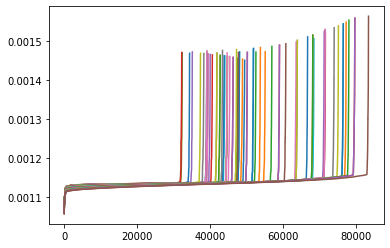

In [18]:
for i in range(company_strengths.shape[1]):
    c = np.array(company_strengths)[:, i, :]
    unique_relationships = list(set(c.flatten()))
    unique_relationships.sort()
    x = list(range(0, len(unique_relationships)))
    plt.plot(x, unique_relationships)

In [76]:
for c in range(10):
    for i in range(company_strengths.shape[1]):
        b = company_strengths[c, i, :]
        print(len(set(b)))
    input('wait')
    #     b_ind = np.argpartition(b, -15)[-15:]
    #     b_ind = b[b_ind]
    #     b_ind.sort()
    #     print(b_ind)

93
98
95
100
100
98
100
97
97
96
104
100
100
94
94
97
97
97
97
97
97
95
95
97
97
98
98
97
97
98
93
99
99
96
98
101
101
93
103
97
97
98
101
98
98
96
101
123
123
103
97
99
99
101
102
99
99
103
102
103
103
101
103
104
104
108


KeyboardInterrupt: Interrupted by user

In [ ]:
square_shape = 881
eye = tf.eye(num_rows=int(square_shape), num_columns=int(square_shape))
# eye = tf.ones(shape=[5,5])
eye = np.array(eye)
for i in range(5):
    eye[1, i] = 1

for i in range(2):
    eye = eye + tf.eye(num_rows=int(square_shape), num_columns=int(square_shape))

eye = tf.constant(eye)
print(eye)

eye_t = tf.transpose(eye)

eye = tf.sparse.from_dense(eye)
eye = tf.sparse.softmax(eye)
eye = tf.sparse.to_dense(eye)
# eye = tf.math.sqrt(eye)
# eye = tf.math.reciprocal_no_nan(eye)

eye_t = tf.sparse.from_dense(eye_t)
eye_t = tf.sparse.softmax(eye_t)
eye_t = tf.sparse.to_dense(eye_t)
# eye_t = tf.math.sqrt(eye_t)
# eye_t = tf.math.reciprocal_no_nan(eye_t)

smooth = tf.math.subtract(tf.add(eye, eye_t), tf.eye(square_shape,square_shape))
# print(tf.multiply(smooth, tf.eye(num_rows=int(square_shape), num_columns=int(square_shape))))
print(smooth)

# print(tf.linalg.set_diag(smooth, tf.constant(5, shape=square_shape, dtype=tf.float32)))

In [ ]:
a_mat = tf.eye(10,10)

a_mat_t = tf.transpose(a_mat)
# a_mat = tf.sparse.from_dense(a_mat)

a_mat = tf.sparse.from_dense(a_mat)
a_mat = tf.sparse.softmax(a_mat)
a_mat = tf.sparse.to_dense(a_mat)

a_mat_t = tf.sparse.from_dense(a_mat_t)
a_mat_t = tf.sparse.softmax(a_mat_t)
a_mat_t = tf.sparse.to_dense(a_mat_t)

print(a_mat)
boolean_mask = tf.math.greater(a_mat, 0)
print(boolean_mask)

In [ ]:
non_zeres = tf.math.logical_not(tf.equal(eye, 0.))
print(non_zeres)

In [ ]:
sparse_softmax = tf.nn.softmax(tf.boolean_mask(eye, non_zeres))
# print(tf.where(non_zeres), tf.ones(shape=non_zeres.shape))
print(sparse_softmax)



In [ ]:
def softmax_(tensor):

    zeros = tf.cast(tf.equal(tensor, 0.), tf.float64)
    cond_ = tf.reduce_sum(zeros)

    def true_fn():
        non_zeros = ~tf.equal(tensor, 0.)
        sparse_softmax = tf.nn.softmax(tf.boolean_mask(tensor, non_zeros))
        sparse_softmax_shape = tf.shape(sparse_softmax)[0]
        orig_shape = tf.shape(tensor)[0]
        shape_ = orig_shape-sparse_softmax_shape
        zeros = tf.zeros(shape=shape_, dtype=tf.float32)
        new_vec = tf.concat([sparse_softmax, zeros], axis=0)

        return new_vec

    def false_fn():

        return tf.zeros(shape=tf.shape(tensor), dtype=tf.float64)

    return tf.cond(tf.equal(cond_, tf.cast(tf.shape(tensor)[0], tf.float64)), false_fn, true_fn)

In [ ]:
def apply_sparse_softmax(time_vector):
    non_zeros = ~tf.equal(time_vector, 0.)

    sparse_softmax = tf.nn.softmax(tf.boolean_mask(time_vector, non_zeros))
    new_time_vector = sparse_softmax * tf.cast(non_zeros, tf.float32) # won't work because dimensions are different
    return time_vector

In [ ]:
x = tf.constant([[6., 2., 0.], [0., 4., 5.]])  # of type tf.float32

k = 2
values, indices = tf.nn.top_k(x, k, sorted=False)  # indices will be [[0, 1], [1, 2]], values will be [[6., 2.], [4., 5.]]

# We need to create full indices like [[0, 0], [0, 1], [1, 2], [1, 1]]
my_range = tf.expand_dims(tf.range(0, indices.get_shape()[0]), 1)  # will be [[0], [1]]
my_range_repeated = tf.tile(my_range, [1, k])  # will be [[0, 0], [1, 1]]

# change shapes to [N, k, 1] and [N, k, 1], to concatenate into [N, k, 2]
full_indices = tf.concat([tf.expand_dims(my_range_repeated, 2), tf.expand_dims(indices, 2)], axis=2)
full_indices = tf.reshape(full_indices, [-1, 2])

print(x)

to_substract = tf.sparse.to_dense(full_indices, x.get_shape(), tf.reshape(values, [-1]))

res = x - to_substract  # res should be all 0.

In [67]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)